In [1]:
# models output : [buy, hold, sell]

In [2]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.losses import huber_loss
from keras.regularizers import L1L2

from collections import deque

import gc


Using TensorFlow backend.


In [3]:
class QNetwork:
    def __init__(self, input_size):
        self.model = make_models(input_size)


In [4]:
def make_models(input_size, output_size=2, n_layers=2):
    inputs = layers.Input(shape=(input_size, ))
    x = layers.Dense(16, activation='relu', kernel_regularizer = L1L2(l2= 0.001))(inputs)

    for i in range(n_layers-1):
        x = layers.Dense(16//(2**(i+1)), kernel_regularizer=L1L2(l2= 0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    outputs = layers.Dense(output_size, activation='linear')(x)

    model = models.Model(inputs, outputs)

    model.compile(optimizer = 'adam',
                 loss = huber_loss)

    return model

In [5]:
class Memory:
    def __init__(self):
        self.buffer = deque(maxlen=memory_size)
        
    def add(self, exp):
        self.buffer.append(exp)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    def __len__(self):
        return len(self.buffer)
    
    

In [6]:
data = pd.read_csv('./data/stock.csv', thousands=',')
d = data.drop(['date', 'close', 'high', 'low'], axis=1)
d.columns

moving = pd.Series()
for cat in d.columns:
    for i in (5, 10, 30, 60):
        moving = pd.concat([moving, d[cat].rolling(i).mean()], axis=1)
        
moving.columns = ['0', 'moving_p5','moving_p10','moving_p30','moving_p60',
                  'moving_vol5','moving_vol10','moving_vol30','moving_vol60',
                  'moving_per5','moving_per10','moving_per30','moving_per60',
                  'moving_pbr5','moving_pbr10','moving_pbr30','moving_pbr60']

moving = moving.drop('0', axis=1)
moving = pd.concat([moving, data.high, data.low], axis=1)

X = moving[61:]
y = data.open[61:]

X = (X - np.min(X))/(np.max(X) - np.min(X))
y = (y - np.min(y))/(np.max(y) - np.min(y))

state = X.values.copy()
p = y.values.copy()
p += 1e-5

In [16]:
# reward clipped version
class Agent:
    def __init__(self, balance, state):
        self.fs = [balance, 0] # [cash, n_stock]
        self.balance = balance
        self.state = state
        self.main = make_models(18)
        self.learner = make_models(18)
        
        self.hist = []
        
        
    def train(self, n_steps):
        for n in range(n_steps):
            self.fs = [1, 0]
            self.balance = 1
            step = 0
            steps = len(self.state)
            for i in range(0, steps-2):
                step += 1
                eps = 0.01 + (EPS - 0.01) * np.exp(-DECAY * step)

                self.learner.set_weights(self.main.get_weights())

                # action 
                if eps > np.random.rand():
                    action = np.random.choice([0, 1, 2])
                else:
                    action = np.argmax(self.main.predict(state[i:i+1]))

                # current stock price
                price = p[i]
                # update fs
                self.fs = self.update_fs(action, price)
                # update balance and make reward
                new_balance = self.update_balance(price)

                reward = ((new_balance / self.balance) - 1)
                reward = self.clipping(reward)
#                 print(reward)

                self.balance = new_balance

                # memorize
                if step > WARMUP:
                    memory.add((state[i:i+1], action, reward, state[i+1:i+2]))

                # learner update
            for _ in range(20):
                inputs = np.zeros((BATCH_SIZE, 18))
                targets = np.zeros((BATCH_SIZE, 3))

                minibatch = memory.sample(BATCH_SIZE)

                for j, (s, a, r, ss) in enumerate(minibatch):
                    inputs[j] = s
                    if not (ss == np.zeros(s.shape)).all(axis=1):
                        target = r + GAMMA * np.argmax(self.learner.predict(ss))
                    else:
                        target = r
                        
                    targets[j] = self.make_target(a, target)
                
#                     targets[j][a] = target

                self.main.fit(inputs, targets, epochs=1, verbose=0)
#                 print(i)


            # as episode end
            self.hist.append(self.balance)
            hist = self.simulation()
            hist = np.array(hist) - BALANCE
            plt.axhline(y=0, color='r', linestyle='-')
            plt.plot(hist)
            plt.show()
            print((n+1), 'steps','mean gain:', np.mean(hist))
#             if len(self.hist)>10 and np.mean(self.hist[10:]) > 1:
#                 break
                    
            
    def update_fs(self, action, price):
        if action == 0: # buy
            n = self.fs[0] // price
            b = self.fs[0] % price
            new_n = self.fs[1]+ n
            return [b, new_n]
        
        elif action == 1: # hold
            return self.fs
        
        else: # sell
            b = self.fs[1] * price
            new_b = self.fs[0]+b
            return [new_b, 0]
        
    
    def update_balance(self, price):
        b = self.fs[0] + self.fs[1] * price
#         print(b, self.fs)
        return b
        
    def simulation(self):
        fs = [BALANCE, 0]
        balance = BALANCE
        hist = []
        for i in range(len(state)-1):
            a = np.argmax(self.main.predict(self.state[i:i+1]))
            price = p[i]
            fs = self.update_fs(a, price)
            balance = self.update_balance(price)
            hist.append(balance)
        return hist
    
    def clipping(self, r):
        if r > 0: return 1
        elif r < 0 : return -1
        else: return 0
        
    def make_target(self, action, target):
        if action == 0 or action == 1: 
            return [target, 0, -target]
        elif action == 2:
            return [-target, 0, target]

In [17]:
GAMMA = 0.99
WARMUP = 20
N_EPISODES = 1000
EPS = 0.3
DECAY = 0.001

memory_size = 1000
BATCH_SIZE = 128

BALANCE = 1

memory = Memory()
a = Agent(1, state)

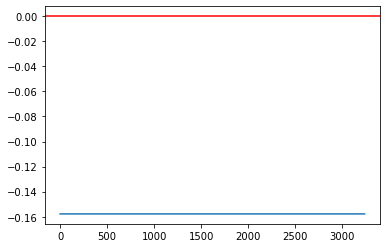

1 steps mean gain: -0.15779974709736758


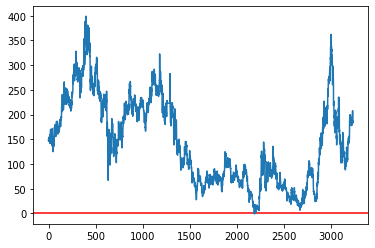

2 steps mean gain: 145.2079129806327


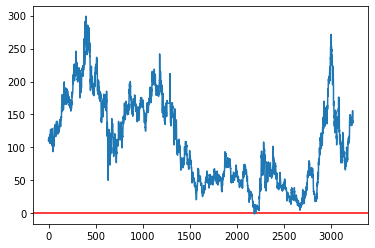

3 steps mean gain: 108.71960800251672


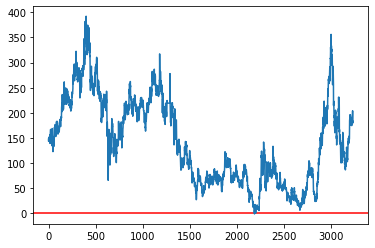

4 steps mean gain: 142.65959328292905


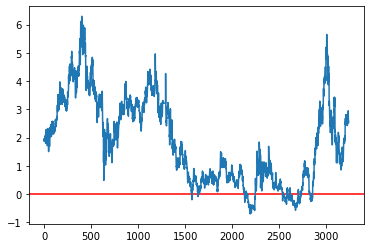

5 steps mean gain: 1.8533863720340462


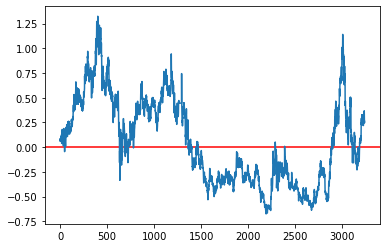

6 steps mean gain: 0.055173272800621405


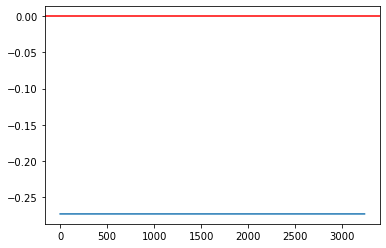

7 steps mean gain: -0.27312909529830964


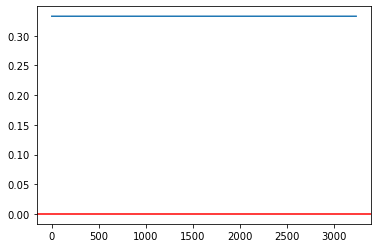

8 steps mean gain: 0.3328054948844695


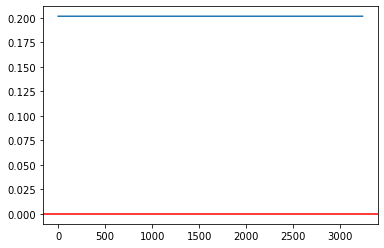

9 steps mean gain: 0.2016208759627551


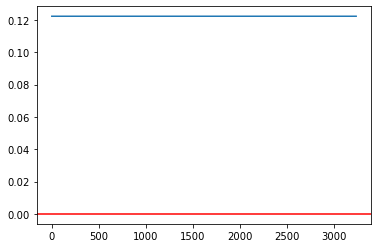

10 steps mean gain: 0.1223301528911378
Wall time: 3min 34s


In [19]:
%%time
a.train(10)

In [18]:
gc.collect()

56905

In [20]:
a.main.predict(state)

array([[-2.9262533 ,  0.47834012,  3.4343143 ],
       [-2.8585973 ,  0.49092236,  3.3431954 ],
       [-2.836584  ,  0.49382123,  3.321303  ],
       ...,
       [-1.9150201 , -0.12859553,  1.682646  ],
       [-1.7710104 , -0.12748682,  1.6008916 ],
       [-1.7467053 , -0.14043291,  1.5867572 ]], dtype=float32)